In [287]:
%reset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import netCDF4
%matplotlib inline

import cmocean
import os
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## First compute grid thicknesses:

In [288]:
grdfile = '/glade/u/home/eyankovsky/CWorthy/epac25km_grd.nc'
grd = xr.open_dataset(grdfile)
dx = 1/grd.pm; dy = 1/grd.pn;
area=dx*dy

def Cs(sigma, theta_s, theta_b):
    C = ( 1 - np.cosh(theta_s * sigma) ) / (np.cosh(theta_s) - 1)
    C = (np.exp(theta_b * C) - 1) / (1 - np.exp(-theta_b))
    return C

def get_thickness(zeta, h):
    
    N = 100
    theta_s = 6
    theta_b = 6
    hc = 250

    k_w = np.linspace(0,N,N+1)

    sigma_w = (k_w - N) / N

    Cs_w = Cs(sigma_w, theta_s, theta_b)

    S_w = np.zeros((N+1, h.shape[0], h.shape[1]))

    for k in range(N+1):
        S_w[k,:,:] = (hc * sigma_w[k] + h*Cs_w[k]) / (hc + h)
                
    z_w = np.zeros((N+1, h.shape[0], h.shape[1]))
    for k in range(N+1):
        z_w[k,:,:] = zeta + (zeta + h)*S_w[k,:,:]

    H = np.diff(z_w,axis=0)
    
    return H
ds = netCDF4.Dataset(grdfile, 'r', format='NETCDF4')
h = ds['h'][:,:]

ds.close()



In [289]:
pdir =  '/glade/derecho/scratch/bachman/EASTPAC_OUTPUT/'
control_spec = 'EASTPAC25KM_Control'
forced_spec1 = 'EASTPAC25KM_Jan'
forced_spec2 = 'EASTPAC25KM_Apr'
forced_spec3 = 'EASTPAC25KM_Jul'
forced_spec4 = 'EASTPAC25KM_Oct'
forced_spec5 = 'EASTPAC25KM_1yr'
forced_spec6 = 'EASTPAC25KM_5yr'

control = sorted(glob(f'{pdir}{control_spec}/*.nc'))
forced_Jan = sorted(glob(f'{pdir}{forced_spec1}/*.nc')); names_Jan = [os.path.basename(x) for x in forced_Jan];
forced_Apr = sorted(glob(f'{pdir}{forced_spec2}/*.nc')); 
forced_Jul = sorted(glob(f'{pdir}{forced_spec3}/*.nc'))
forced_Oct = sorted(glob(f'{pdir}{forced_spec4}/*.nc'))
forced_1yr = sorted(glob(f'{pdir}{forced_spec5}/*.nc')); names_1yr = [os.path.basename(x) for x in forced_1yr];
forced_5yr = sorted(glob(f'{pdir}{forced_spec6}/*.nc'))



index_list = [i for i in range(len(forced_5yr))]


In [290]:
print(len(control), len(forced_Jan), len(forced_Apr), len(forced_Jul), len(forced_Oct), len(forced_1yr), len(forced_5yr))


609 286 283 281 278 609 844


In [334]:
print(names_Jan[42])

eastpac25km_rst.19980127000000.nc


In [332]:
%cd /glade/derecho/scratch/bachman/EASTPAC_OUTPUT/EASTPAC25KM_Control/

# #for fn in names_Jan[60:61]:

fn = names_Jan[41]   #41 is the last index that we have matching data for

f = netCDF4.Dataset(fn, 'r', format='NETCDF4')
ssh = f['zeta'][-1,:,:]
H = get_thickness(ssh,h)
f.close()
    
ds_control = xr.open_dataset(fn)
ds_pert    = xr.open_dataset(f'{pdir}{forced_spec1}/{fn}')
    
ALK_control= (ds_control.Alk[-1,:,:,:]*H).sum(axis=0)*area;
ALK_pert    = (ds_pert.Alk[-1,:,:,:]*H).sum(axis=0)*area

u_control = (ds_control.u[-1,:,:,:])
u_pert = (ds_pert.u[-1,:,:,:])

dALK = ALK_pert-ALK_control
du = u_control-u_pert

/glade/derecho/scratch/bachman/EASTPAC_OUTPUT/EASTPAC25KM_Control


0.0

In [266]:
#REFERENCED TO CONTROL:

for i in range(60,61):
    f = netCDF4.Dataset(control[i], 'r', format='NETCDF4')
    ssh = f['zeta'][-1,:,:]
    f.close()

    H = get_thickness(ssh,h)
    
    ALK_control = ((xr.open_dataset(control[i]).Alk[-1,:,:,:])*H).sum(axis=0)*area;
    ALK_1yr     =((xr.open_dataset(forced_1yr[i]).Alk[-1,:,:,:])*H).sum(axis=0)*area

    time1 = (xr.open_dataset(control[i]).ocean_time)
    time2 = (xr.open_dataset(forced_1yr[i]).ocean_time)

    dALK = ALK_1yr-ALK_control
    print(time1,time2)

print(i)

<xarray.DataArray 'ocean_time' (time: 2)>
array([68427000., 68428800.])
Dimensions without coordinates: time
Attributes:
    long_name:  Time since 1995/01/01
    units:      second <xarray.DataArray 'ocean_time' (time: 2)>
array([68427000., 68428800.])
Dimensions without coordinates: time
Attributes:
    long_name:  Time since 1995/01/01
    units:      second
60


In [268]:
time0 = []
time1 = []

for i in range(0,10):
    ds0 = xr.open_dataset(control[i])
    ds1 = xr.open_dataset(forced_1yr[i])

    time0.append(ds0.ocean_time[0].values/86400)
    time1.append(ds1.ocean_time[0].values/86400)

#plt.plot(np.array(time1)-np.array(time0)) ##times are the same for these two runs

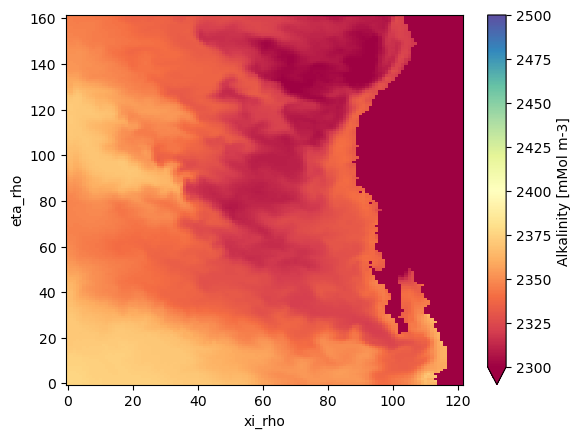

60


In [270]:
#REFERENCED TO CONTROL:

for i in range(60,61):
    f = netCDF4.Dataset(control[i], 'r', format='NETCDF4')
    ssh = f['zeta'][-1,:,:]
    f.close()

    H = get_thickness(ssh,h)
    
    #ALK_control = (xr.open_dataset(control[i]).Alk[-1,:,:,:])#*H).sum(axis=0)*area;
    ALK_1yr     = (xr.open_dataset(forced_1yr[i]).Alk[-1,-1,:,:])#*H).sum(axis=0)*area

    dALK = ALK_1yr#-ALK_control
    
    (dALK).plot(cmap='Spectral',vmin=2300,vmax=2500)
    plt.show()
    print(i)

In [274]:


for i in range(50,51):
    test1 = xr.open_dataset(ds1[i]).u[0,-1,:,:]
    test2 = xr.open_dataset(ds2[i]).u[0,-1,:,:]
    test3 = xr.open_dataset(ds3[i]).u[0,-1,:,:]
    test4 = xr.open_dataset(ds4[i]).u[0,-1,:,:]    
    try:
        xr.testing.assert_equal(test3, test4)
    except:
        print(i)
        break
print('done') 

KeyError: 50

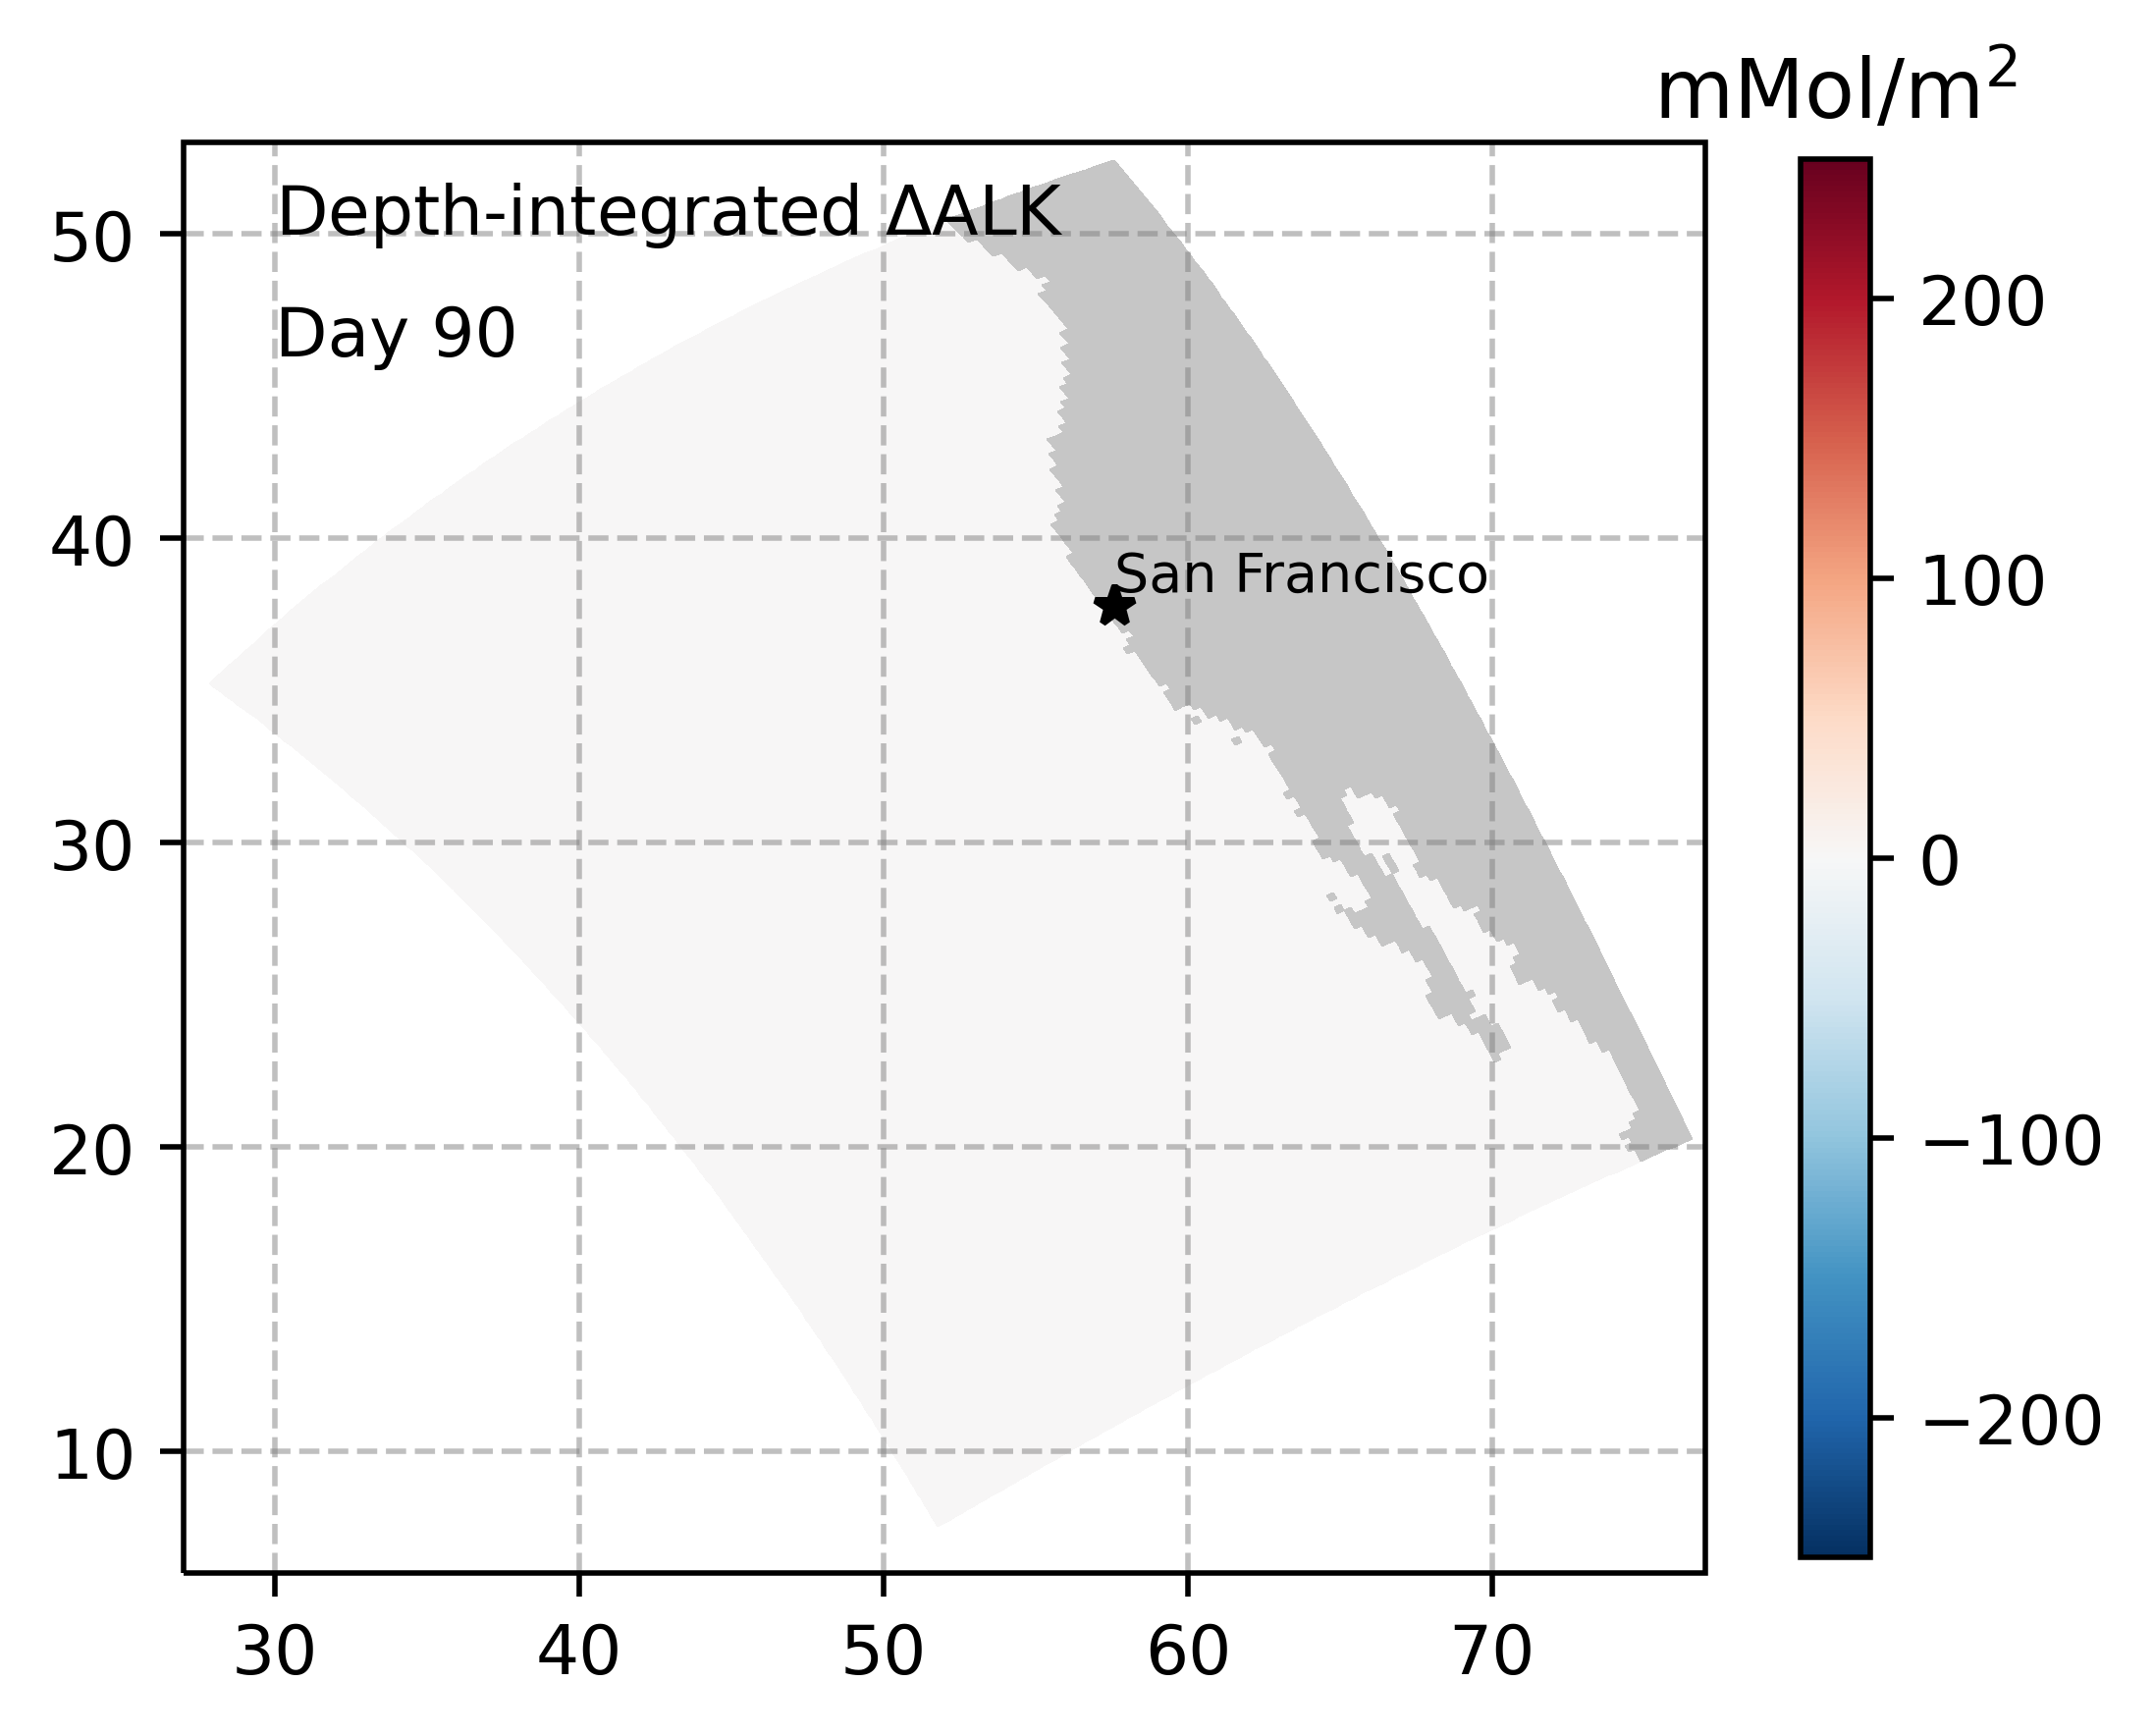

In [275]:
fig = plt.figure(figsize=(5,5),dpi=500)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

test=dALK
mask= grd.mask_rho.where(grd.mask_rho>0)

#test = test.where(test>0).fillna(0.)
#test.isnan(te
sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                test*mask/area,
                transform=ccrs.PlateCarree(),
                cmap='RdBu_r',vmin=-250,vmax=250);
cb = fig.colorbar(sca, ax=ax, shrink=0.74)

sca = ax.pcolormesh(grd.lon_rho-180,
                grd.lat_rho,
                grd.mask_rho.where(grd.mask_rho<1),
                transform=ccrs.PlateCarree(),
                cmap='Greys',vmin=-1,vmax=2);


cb.ax.set_title('mMol/m$^2$')
true_lat = 37.78
true_lon = -122.43+180
plt.plot(true_lon,true_lat,'*',color='k',markersize=6,transform=ccrs.PlateCarree())
plt.text(true_lon,true_lat+.5,'San Francisco',fontsize=8,color='k',transform=ccrs.PlateCarree())
plt.text(30,50,'Depth-integrated $\Delta$ALK', fontsize=10)

plt.text(30,46,'Day 90', fontsize=10)
# plt.plot(xloc-10*resfac,yloc,'*',color='b')
# plt.contour(alk_flux[0,:])

#plt.text(xloc,yloc+2,'San Francisco',color='y')

ax.set_extent([27, 77, 6, 53], ccrs.PlateCarree())
ax.set_xticks(np.arange(30, 80, 10), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10, 60, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)  
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                   color='gray', alpha=0.5, linestyle='--')

In [70]:
timediff= (xr.open_dataset(control[5]).ocean_time[0]-xr.open_dataset(control[0]).ocean_time[0])/86400
print(timediff)
total_alk = (xr.open_dataset('/glade/u/home/eyankovsky/CWorthy/ALK_forcing.nc').ALK[0,:]*86400*(timediff))*area
print(np.nansum(total_alk))
print(np.nansum(dALK))
print(np.nansum(dALK)/np.nansum(total_alk))

<xarray.DataArray 'ocean_time' ()>
array(5.)
2115208804940.0469
2538250565964.539
1.200000000017248


In [71]:
np.nanmin(dALK)

-334010912.0